# Heat Transfer II
February 26th, 2025

Data analysis & Comsol post-processing by Alex Quemel, Rahil Shaik, Sneha Kancharla, and Ethan Mibu

### Pre-processing

In [426]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

In [427]:
data = {
    'Flow Rate (SCFM)': [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4],
    'Thermistor #': [4, 5, 6, 4, 5, 6, 4, 5, 6, 4, 5, 6],
    'Temperature 1 (°C)': [115.8, 113.6, 111.7, 113.3, 110.8, 108.4, 112.0, 109.1, 106.3, 109.0, 106.8, 104.1],
    'Temperature 2 (°C)': [116.2, 114.8, 112.7, 116.0, 113.9, 111.1, 115.7, 113.2, 110.1, 115.1, 112.0, 108.5],
    'Temperature 3 (°C)': [None, None, None, 115.8, 113.4, 111.0, 114.7, 111.8, 108.7, None, None, None],\
    'Q_in (W)': [35.50, 35.50, 35.50, 42.33, 42.33, 42.33, 44.83, 44.83, 44.83, 45.13, 45.13, 45.13],
}

In [428]:
df = pd.DataFrame(data)
df["Avg Temp (°C)"] = df[["Temperature 1 (°C)", "Temperature 2 (°C)", "Temperature 3 (°C)"]].mean(axis=1)
df["Avg Temp (K)"] = df["Avg Temp (°C)"] + 273.15

In [429]:
def get_positions(thermistor_number):
    if thermistor_number == 6:
        return .0125
    elif thermistor_number == 5:
        return .0125 + .0254
    elif thermistor_number == 4:
        return .0125 + .0254 + .0254
    else:
        return None
    
df["positions (m)"] = df["Thermistor #"].apply(get_positions)

## Experimental Data Analysis

### Question 2
### From an appropriate plot of your thermistor data, obtain the convective heat-transfer coefficient at the end of the rod, h, for all air flow rates. Fit your data utilizing the method you determine most appropriate to extrapolate the temperature and its gradient at the brass-rod face.


Our goal should be to plot temperature readings across the position and extrapolate the line to the ends of the rod. We will use this line to find a linear expression for T(z)

In [430]:
df

,Flow Rate (SCFM),Thermistor #,Temperature 1 (°C),Temperature 2 (°C),Temperature 3 (°C),Q_in (W),Avg Temp (°C),Avg Temp (K),positions (m)
0,1,4,115.8,116.2,NaN,35.50,116.000000,389.150000,0.0633
1,1,5,113.6,114.8,NaN,35.50,114.200000,387.350000,0.0379
2,1,6,111.7,112.7,NaN,35.50,112.200000,385.350000,0.0125
3,2,4,113.3,116.0,115.8,42.33,115.033333,388.183333,0.0633
4,2,5,110.8,113.9,113.4,42.33,112.700000,385.850000,0.0379
5,2,6,108.4,111.1,111.0,42.33,110.166667,383.316667,0.0125
6,3,4,112.0,115.7,114.7,44.83,114.133333,387.283333,0.0633
7,3,5,109.1,113.2,111.8,44.83,111.366667,384.516667,0.0379
8,3,6,106.3,110.1,108.7,44.83,108.366667,381.516667,0.0125
9,4,4,109.0,115.1,NaN,45.13,112.050000,385.200000,0.0633


In [431]:
df_1 = df[df["Flow Rate (SCFM)"] == 1]
df_2 = df[df["Flow Rate (SCFM)"] == 2]
df_3 = df[df["Flow Rate (SCFM)"] == 3]
df_4 = df[df["Flow Rate (SCFM)"] == 4]

Text(0.5, 1.0, 'Temperature readings down brass rod')

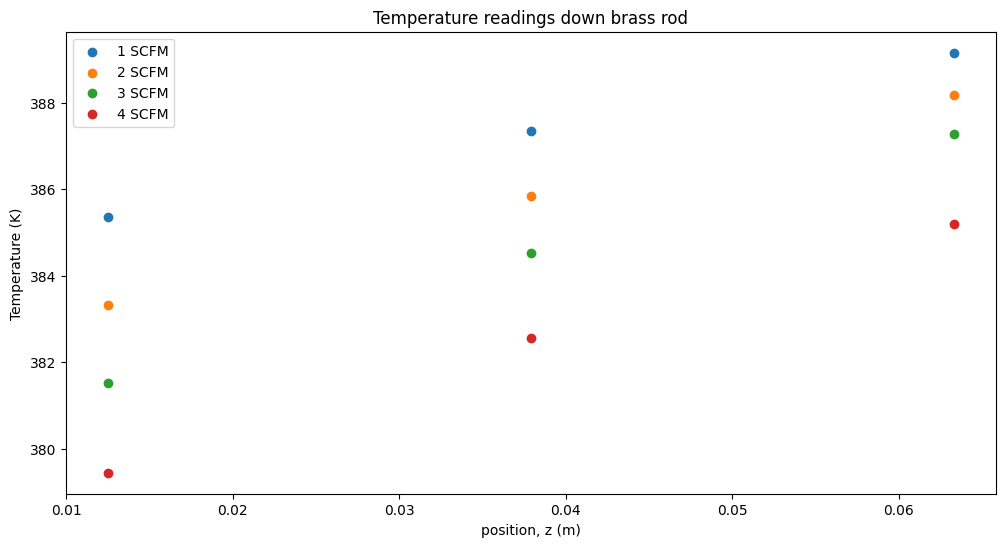

In [432]:
plt.figure(figsize=(12,6))
plt.scatter(df_1["positions (m)"], df_1["Avg Temp (K)"], label = "1 SCFM")
plt.scatter(df_2["positions (m)"], df_2["Avg Temp (K)"], label = "2 SCFM")
plt.scatter(df_3["positions (m)"], df_3["Avg Temp (K)"], label = "3 SCFM")
plt.scatter(df_4["positions (m)"], df_4["Avg Temp (K)"], label = "4 SCFM")
plt.legend()
plt.xlabel("position, z (m)")
plt.ylabel("Temperature (K)")
plt.title("Temperature readings down brass rod")

Now, that we have this plot, lets find an expression that defines the temperature across Z. Theoretically, at z = 0, the temperature should be the same as the heater, any discrepancy will be defined as a bias.


We need to use this temperature gradient to solve for convective heat transfer coefficient. Because radial heat flux dominates convective heat transfer, we should compute radial heat flux using an energy balance.

We start with an energy balance:
$$ Q_{in} = Q_{axial} + Q_{radial} + Q_{losses} $$

Then, we solve for Q_losses using our bias value from the heater input to the brass rod as:

$$ Q_{losses} = Q_{in} \times \frac{T_{heater} - T_{brass,heater}}{T_{heater} - T_{\infin}}$$

$$ Q_{radial} = Q_{in} - Q_{axial} - Q_{losses} $$

Then, we get q_radial by combining Fourier's law with Newton's law of cooling:

$$ q_{radial} = Q_{radial} * A_{rod \ face} = h(T_{surface} - T_{air})$$

Isolating h:

$$h_{conv} = \frac{Q_{radial}}{ A_{rod \ face}(T_{surface}-T_{air})}$$

Which gives convective heat transfer coefficient using radial heat flux. 

First, we must calculate Q_axial by finding an expression for T(z) down the rod

In [433]:
rod_length = 0.081 # m
rod_diam = .025 # m
heater_input = 133 + 273.15 # K
k_brass = 120 # W/mK
T_air = 20 + 273.15 # K
T_air_jet = 20.6 + 273.15 # K
k_nylon = 0.25 # W/mK
w_nylon = 0.0254 # m

In [434]:
slope_1, intercept_1, _, _, _ = stats.linregress(df_1["positions (m)"], df_1["Avg Temp (K)"])

slope_2, intercept_2, _, _, _ = stats.linregress(df_2["positions (m)"], df_2["Avg Temp (K)"])

slope_3, intercept_3, _, _, _ = stats.linregress(df_3["positions (m)"], df_3["Avg Temp (K)"])

slope_4, intercept_4, _, _, _ = stats.linregress(df_4["positions (m)"], df_4["Avg Temp (K)"])

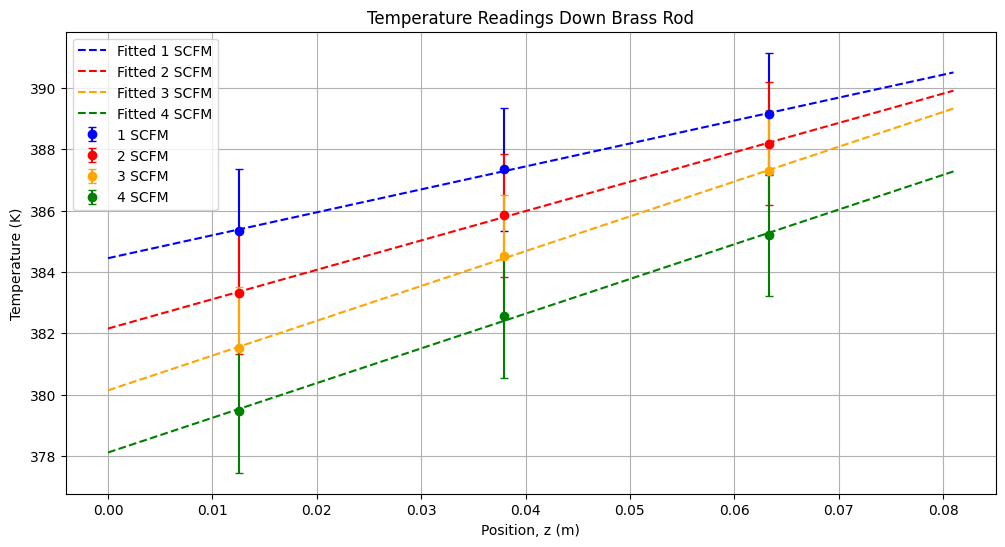

In [435]:
plt.figure(figsize=(12,6))

error_1 = np.full_like(df_1["Avg Temp (K)"], 2)  # Replace with actual std deviation
error_2 = np.full_like(df_2["Avg Temp (K)"], 2)  
error_3 = np.full_like(df_3["Avg Temp (K)"], 2)  
error_4 = np.full_like(df_4["Avg Temp (K)"], 2)  

# Raw data with error bars
plt.errorbar(df_1["positions (m)"], df_1["Avg Temp (K)"], yerr=error_1, fmt='o', label="1 SCFM", capsize=3, color = "blue")
plt.errorbar(df_2["positions (m)"], df_2["Avg Temp (K)"], yerr=error_2, fmt='o', label="2 SCFM", capsize=3, color = "red")
plt.errorbar(df_3["positions (m)"], df_3["Avg Temp (K)"], yerr=error_3, fmt='o', label="3 SCFM", capsize=3, color = "orange")
plt.errorbar(df_4["positions (m)"], df_4["Avg Temp (K)"], yerr=error_4, fmt='o', label="4 SCFM", capsize=3, color = "green")

plt.xlabel("Position, z (m)")
plt.ylabel("Temperature (K)")
plt.title("Temperature Readings Down Brass Rod")

positions = np.linspace(0, rod_length, 50)

# Fit lines
plt.plot(positions, [pos * slope_1 + intercept_1 for pos in positions], label="Fitted 1 SCFM", linestyle="--", color = "blue")
plt.plot(positions, [pos * slope_2 + intercept_2 for pos in positions], label="Fitted 2 SCFM", linestyle="--", color = "red")
plt.plot(positions, [pos * slope_3 + intercept_3 for pos in positions], label="Fitted 3 SCFM", linestyle="--", color = "orange")
plt.plot(positions, [pos * slope_4 + intercept_4 for pos in positions], label="Fitted 4 SCFM", linestyle="--", color = "green")

# Heater input temperature line
# plt.axhline(y=133 + 273.15, linestyle="--", label="Heater Input Temperature", color="black")

plt.legend()
plt.grid(True)
plt.show()


The end of each plot line should approach 406 K heating input temperature but it is a bit off, so there is heat loss at the heater-brass interface. Let's compute that loss.

In [436]:
bias_1 = heater_input - (slope_1 * rod_length + intercept_1)
bias_2 = heater_input - (slope_2 * rod_length + intercept_2)
bias_3 = heater_input - (slope_3 * rod_length + intercept_3)
bias_4 = heater_input - (slope_4 * rod_length + intercept_4)

In [437]:
print("Bias for 1 SCFM:", bias_1, "K")
print("Bias for 2 SCFM:", bias_2, "K")
print("Bias for 3 SCFM:", bias_3, "K")
print("Bias for 4 SCFM:", bias_4, "K")

Bias for 1 SCFM: 15.642650918635127 K
Bias for 2 SCFM: 16.237664041994776 K
Bias for 3 SCFM: 16.818525809273865 K
Bias for 4 SCFM: 18.871555118110166 K


Using this bias and the slope were able to extract from the linear fit line, we can define expressions for dT/dz for each flow rate, enabling us to compute each h value

In [438]:
def Q_axial_1(z):
    return (k_brass * ((rod_diam / 2) ** 2) * np.pi * slope_1) * z 

def Q_axial_2(z):
    return (k_brass * ((rod_diam / 2) ** 2) * np.pi * slope_2) * z 

def Q_axial_3(z):
    return (k_brass * ((rod_diam / 2) ** 2) * np.pi * slope_3) * z 

def Q_axial_4(z):    
    return (k_brass * ((rod_diam / 2) ** 2) * np.pi * slope_4) * z 

In [439]:
df_1["Q_axial (W)"] = df_1["positions (m)"].apply(Q_axial_1)
df_2["Q_axial (W)"] = df_2["positions (m)"].apply(Q_axial_2)
df_3["Q_axial (W)"] = df_3["positions (m)"].apply(Q_axial_3)
df_4["Q_axial (W)"] = df_4["positions (m)"].apply(Q_axial_4)

In [440]:
df_1

,Flow Rate (SCFM),Thermistor #,Temperature 1 (°C),Temperature 2 (°C),Temperature 3 (°C),Q_in (W),Avg Temp (°C),Avg Temp (K),positions (m),Q_axial (W)
0,1,4,115.8,116.2,NaN,35.5,116.0,389.15,0.0633,0.278917
1,1,5,113.6,114.8,NaN,35.5,114.2,387.35,0.0379,0.166998
2,1,6,111.7,112.7,NaN,35.5,112.2,385.35,0.0125,0.055078


### Via extrapolation, the temperature at the brass rod faces are below as:

In [441]:
print("1 SCFM tempearature at impinging jet brass rod face", intercept_1, "K")
print("1 SCFM  gradient at impinging jet brass rod face", slope_1, "K/m")

print("2 SCFM tempearature at impinging jet brass rod face", intercept_2, "K")
print("2 SCFM  gradient at impinging jet brass rod face", slope_2, "K/m")

print("3 SCFM tempearature at impinging jet brass rod face", intercept_3, "K")
print("3 SCFM  gradient at impinging jet brass rod face", slope_3, "K/m")

print("4 SCFM tempearature at impinging jet brass rod face", intercept_4, "K")
print("4 SCFM  gradient at impinging jet brass rod face", slope_4, "K/m")


1 SCFM tempearature at impinging jet brass rod face 384.44829396325457 K
1 SCFM  gradient at impinging jet brass rod face 74.80314960629944 K/m
2 SCFM tempearature at impinging jet brass rod face 382.15249343832016 K
2 SCFM  gradient at impinging jet brass rod face 95.80052493438336 K/m
3 SCFM tempearature at impinging jet brass rod face 380.1365923009624 K
3 SCFM  gradient at impinging jet brass rod face 113.51706036745378 K/m
4 SCFM tempearature at impinging jet brass rod face 378.11013779527565 K
4 SCFM  gradient at impinging jet brass rod face 113.18897637795277 K/m


Let's see how gradient scales with position

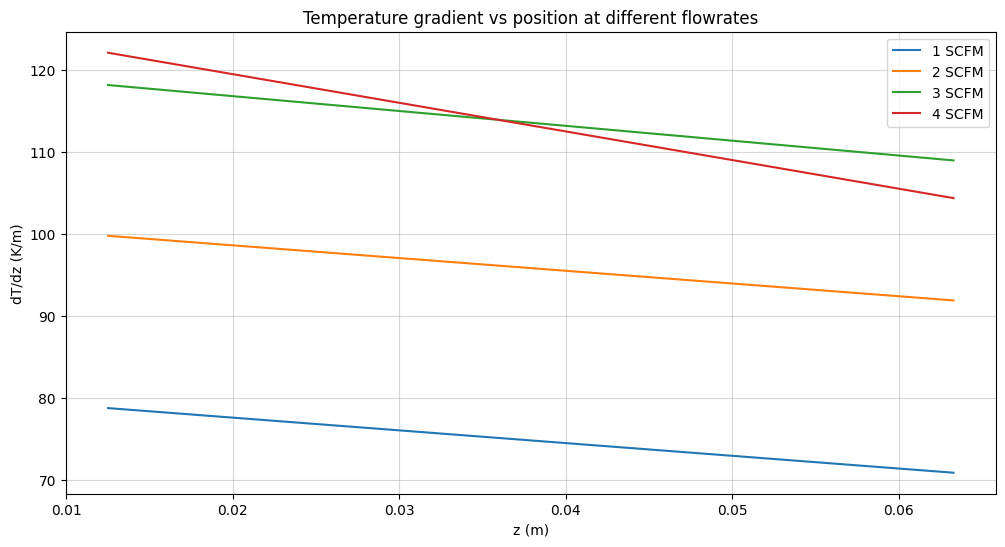

In [442]:
dt_dz_1 = np.gradient(df_1["Avg Temp (K)"], df_1["positions (m)"])
dt_dz_2 = np.gradient(df_2["Avg Temp (K)"], df_2["positions (m)"])
dt_dz_3 = np.gradient(df_3["Avg Temp (K)"], df_3["positions (m)"])
dt_dz_4 = np.gradient(df_4["Avg Temp (K)"], df_4["positions (m)"])

plt.figure(figsize=(12,6))
plt.plot(df_1["positions (m)"], dt_dz_1, label="1 SCFM")
plt.plot(df_2["positions (m)"], dt_dz_2, label="2 SCFM")
plt.plot(df_3["positions (m)"], dt_dz_3, label="3 SCFM")
plt.plot(df_4["positions (m)"], dt_dz_4, label="4 SCFM")
plt.xlabel("z (m)")
plt.ylabel("dT/dz (K/m)")
plt.title("Temperature gradient vs position at different flowrates")
plt.grid(alpha=0.5)
plt.legend()

Now that we have Q_axial and Q_in, we need Q_losses:

In [443]:
T_brass_heater_1 = slope_1 * rod_length + intercept_1
T_brass_heater_2 = slope_2 * rod_length + intercept_2
T_brass_heater_3 = slope_3 * rod_length + intercept_3
T_brass_heater_4 = slope_4 * rod_length + intercept_4

In [444]:
df_1["Q_losses (W)"] = df_1["Q_in (W)"] * (heater_input - T_brass_heater_1) / (heater_input - T_air)
df_2["Q_losses (W)"] = df_2["Q_in (W)"] * (heater_input - T_brass_heater_2) / (heater_input - T_air)
df_3["Q_losses (W)"] = df_3["Q_in (W)"] * (heater_input - T_brass_heater_3) / (heater_input - T_air)
df_4["Q_losses (W)"] = df_4["Q_in (W)"] * (heater_input - T_brass_heater_4) / (heater_input - T_air)

Let's compute Q_radial using the energy balance

In [445]:
df_1["Q_rad (W)"] = df_1["Q_in (W)"] - df_1["Q_axial (W)"] - df_1["Q_losses (W)"]
df_2["Q_rad (W)"] = df_2["Q_in (W)"] - df_2["Q_axial (W)"] - df_2["Q_losses (W)"]
df_3["Q_rad (W)"] = df_3["Q_in (W)"] - df_3["Q_axial (W)"] - df_3["Q_losses (W)"]
df_4["Q_rad (W)"] = df_4["Q_in (W)"] - df_4["Q_axial (W)"] - df_4["Q_losses (W)"]

Combining Fourier's law and Newton's Law of Cooling gives convective heat transfer coefficient

We are going to use the circumference of the radius face as the surface area for convective heat transfer

In [446]:
df_1["h_conv (W/m^2 K)"] = df_1["Q_rad (W)"] / ( (2 * np.pi * (rod_diam / 2)) * (heater_input - T_brass_heater_1))
df_2["h_conv (W/m^2 K)"] = df_2["Q_rad (W)"] / ( (2 * np.pi * (rod_diam / 2)) * (heater_input - T_brass_heater_2))
df_3["h_conv (W/m^2 K)"] = df_3["Q_rad (W)"] / ( (2 * np.pi * (rod_diam / 2)) * (heater_input - T_brass_heater_3))
df_4["h_conv (W/m^2 K)"] = df_4["Q_rad (W)"] / ( (2 * np.pi * (rod_diam / 2)) * (heater_input - T_brass_heater_4))

In [447]:
df_2

,Flow Rate (SCFM),Thermistor #,Temperature 1 (°C),Temperature 2 (°C),Temperature 3 (°C),Q_in (W),Avg Temp (°C),Avg Temp (K),positions (m),Q_axial (W),Q_losses (W),Q_rad (W),h_conv (W/m^2 K)
3,2,4,113.3,116.0,115.8,42.33,115.033333,388.183333,0.0633,0.357209,6.082658,35.890133,28.142433
4,2,5,110.8,113.9,113.4,42.33,112.700000,385.850000,0.0379,0.213874,6.082658,36.033468,28.254826
5,2,6,108.4,111.1,111.0,42.33,110.166667,383.316667,0.0125,0.070539,6.082658,36.176803,28.367219


### Question 3
$$\textbf{Calculate the axial heat flux leaving the brass-rod face.}$$

In [448]:
df_1["q_axial (W / m^2)"] = df_1["Q_axial (W)"] / ((rod_diam / 2) ** 2 * np.pi)
df_2["q_axial (W / m^2)"] = df_2["Q_axial (W)"] / ((rod_diam / 2) ** 2 * np.pi)
df_3["q_axial (W / m^2)"] = df_3["Q_axial (W)"] / ((rod_diam / 2) ** 2 * np.pi)
df_4["q_axial (W / m^2)"] = df_4["Q_axial (W)"] / ((rod_diam / 2) ** 2 * np.pi)

In [449]:
df_1["q_rad (W / m^2)"] = df_1["Q_rad (W)"] / (2 * np.pi * (rod_diam / 2) * rod_length)
df_2["q_rad (W / m^2)"] = df_2["Q_rad (W)"] / (2 * np.pi * (rod_diam / 2) * rod_length)
df_3["q_rad (W / m^2)"] = df_3["Q_rad (W)"] / (2 * np.pi * (rod_diam / 2) * rod_length)
df_4["q_rad (W / m^2)"] = df_4["Q_rad (W)"] / (2 * np.pi * (rod_diam / 2) * rod_length)

$$\textbf {Estimate the overall radial heat-transfer coefficient, 
U, between the brass rod and the surrounding air. }$$
$$ \textbf{ You must consider what heat-transfer resistances exist between the rod and the air.}$$

The heat transfer resistance between the rod and the air is only given by convective heat transfer at the face and radial heat transfer through the nylon. Let's first find the heat transfer resistances.

We start with brass conduction resistance:

In [450]:
def T_1(z):
    return slope_1 * z + intercept_1

def T_2(z):
    return slope_2 * z + intercept_2

def T_3(z):
    return slope_3 * z + intercept_3

def T_4(z):
    return slope_4 * z + intercept_4

In [451]:
df_1["R_brass (K/W)"] = ( T_1(df_1["positions (m)"])- T_air_jet) / df_1["q_rad (W / m^2)"]
df_2["R_brass (K/W)"] = ( T_2(df_2["positions (m)"])- T_air_jet) / df_2["q_rad (W / m^2)"]
df_3["R_brass (K/W)"] = ( T_3(df_3["positions (m)"])- T_air_jet) / df_3["q_rad (W / m^2)"]
df_4["R_brass (K/W)"] = ( T_4(df_4["positions (m)"])- T_air_jet) / df_4["q_rad (W / m^2)"]

nylon conduction resistance, which we will compute using an energy balance to get T_nylon

$$ T_{nylon} = T_{brass} - Q_{radial} R_{brass}$$

Using this we can compute R_nylon

$$ R_{nylon} = \frac{T_{nylon} - T_{surface}}{Q_{radial}}$$

In [452]:
df_1["T_nylon (K)"] = T_1(df_1["positions (m)"])  - df_1["Q_rad (W)"] * df_1["R_brass (K/W)"]
df_2["T_nylon (K)"] = T_2(df_2["positions (m)"])  - df_2["Q_rad (W)"] * df_2["R_brass (K/W)"]
df_3["T_nylon (K)"] = T_3(df_3["positions (m)"])  - df_3["Q_rad (W)"] * df_3["R_brass (K/W)"]
df_4["T_nylon (K)"] = T_4(df_4["positions (m)"])  - df_4["Q_rad (W)"] * df_4["R_brass (K/W)"]

In [453]:
df_1["R_nylon (K/W)"] = (df_1["T_nylon (K)"] - T_air) / df_1["Q_rad (W)"]
df_2["R_nylon (K/W)"] = (df_2["T_nylon (K)"] - T_air) / df_2["Q_rad (W)"]
df_3["R_nylon (K/W)"] = (df_3["T_nylon (K)"] - T_air) / df_3["Q_rad (W)"]
df_4["R_nylon (K/W)"] = (df_4["T_nylon (K)"] - T_air) / df_4["Q_rad (W)"]

In [454]:
df_1

,Flow Rate (SCFM),Thermistor #,Temperature 1 (°C),Temperature 2 (°C),Temperature 3 (°C),Q_in (W),Avg Temp (°C),Avg Temp (K),positions (m),Q_axial (W),Q_losses (W),Q_rad (W),h_conv (W/m^2 K),q_axial (W / m^2),q_rad (W / m^2),R_brass (K/W),T_nylon (K),R_nylon (K/W)
0,1,4,115.8,116.2,NaN,35.5,116.0,389.15,0.0633,0.278917,4.914284,30.306799,24.668335,568.204724,4763.927776,0.020032,388.576213,3.148673
1,1,5,113.6,114.8,NaN,35.5,114.2,387.35,0.0379,0.166998,4.914284,30.418718,24.759432,340.204724,4781.520369,0.019561,386.688300,3.075024
2,1,6,111.7,112.7,NaN,35.5,112.2,385.35,0.0125,0.055078,4.914284,30.530637,24.850529,112.204724,4799.112961,0.019094,384.800387,3.001915


convective resistance:

In [455]:
df_1["R_conv (K/W)"] = (intercept_1 - T_air_jet) / df_1["Q_rad (W)"]
df_2["R_conv (K/W)"] = (intercept_2 - T_air_jet) / df_2["Q_rad (W)"]
df_3["R_conv (K/W)"] = (intercept_3 - T_air_jet) / df_3["Q_rad (W)"]
df_4["R_conv (K/W)"] = (intercept_4 - T_air_jet) / df_4["Q_rad (W)"]

$$ \frac{1}{U} = R_{brass} + R_{nylon} + R_{conv} $$

In [456]:
df_1["U (W / m^2 K)"] = (df_1["R_brass (K/W)"] + df_1["R_nylon (K/W)"] + df_1["R_conv (K/W)"]) ** -1
df_2["U (W / m^2 K)"] = (df_2["R_brass (K/W)"] + df_2["R_nylon (K/W)"] + df_2["R_conv (K/W)"]) ** -1
df_3["U (W / m^2 K)"] = (df_3["R_brass (K/W)"] + df_3["R_nylon (K/W)"] + df_3["R_conv (K/W)"]) ** -1
df_4["U (W / m^2 K)"] = (df_4["R_brass (K/W)"] + df_4["R_nylon (K/W)"] + df_4["R_conv (K/W)"]) ** -1

In [463]:
print((df_1["R_brass (K/W)"] + df_1["R_nylon (K/W)"] + df_1["R_conv (K/W)"]))

0    6.161377
1    6.076246
2    5.991740
dtype: float64


In [457]:
df_1

,Flow Rate (SCFM),Thermistor #,Temperature 1 (°C),Temperature 2 (°C),Temperature 3 (°C),Q_in (W),Avg Temp (°C),Avg Temp (K),positions (m),Q_axial (W),Q_losses (W),Q_rad (W),h_conv (W/m^2 K),q_axial (W / m^2),q_rad (W / m^2),R_brass (K/W),T_nylon (K),R_nylon (K/W),R_conv (K/W),U (W / m^2 K)
0,1,4,115.8,116.2,NaN,35.5,116.0,389.15,0.0633,0.278917,4.914284,30.306799,24.668335,568.204724,4763.927776,0.020032,388.576213,3.148673,2.992672,0.162301
1,1,5,113.6,114.8,NaN,35.5,114.2,387.35,0.0379,0.166998,4.914284,30.418718,24.759432,340.204724,4781.520369,0.019561,386.688300,3.075024,2.981661,0.164575
2,1,6,111.7,112.7,NaN,35.5,112.2,385.35,0.0125,0.055078,4.914284,30.530637,24.850529,112.204724,4799.112961,0.019094,384.800387,3.001915,2.970730,0.166896


In [464]:
df_1[["U (W / m^2 K)", "h_conv (W/m^2 K)"]]

,U (W / m^2 K),h_conv (W/m^2 K)
0,0.162301,24.668335
1,0.164575,24.759432
2,0.166896,24.850529


In [459]:
df_2[["U (W / m^2 K)", "h_conv (W/m^2 K)"]]

,U (W / m^2 K),h_conv (W/m^2 K)
3,0.195619,28.142433
4,0.199041,28.254826
5,0.202555,28.367219


In [460]:
df_3[["U (W / m^2 K)", "h_conv (W/m^2 K)"]]

,U (W / m^2 K),h_conv (W/m^2 K)
6,0.208987,28.566664
7,0.213334,28.695243
8,0.217825,28.823821


In [461]:
df_4[["U (W / m^2 K)", "h_conv (W/m^2 K)"]]

,U (W / m^2 K),h_conv (W/m^2 K)
9,0.210618,25.078811
10,0.215082,25.193070
11,0.219695,25.307330


## COMSOL Data Analysis & Report Tasks

#### Reading in data

In [465]:
df_sim_1 = pd.read_csv('data/Heat Transfer Lab COMSOL Data - 1 SCFM Data.csv')
df_sim_2 = pd.read_csv('data/Heat Transfer Lab COMSOL Data - 2 SCFM Data.csv')
df_sim_3 = pd.read_csv('data/Heat Transfer Lab COMSOL Data - 3 SCFM Data.csv')
df_sim_4 = pd.read_csv('data/Heat Transfer Lab COMSOL Data - 4 SCFM Data.csv')

In [466]:
df_sim_1.head()

,r,z,T (K)
0,0.001092,-0.008912,313.091756
1,0.000000,-0.010000,293.600000
2,0.001590,-0.010000,293.600000
3,0.000000,-0.008002,317.777552
4,0.002418,-0.008780,307.997580


### Question 3
$$ \textbf{Plot the axial temperatures along the rod along the centerline (i.e., T(0, z>0)) and compare them to your experimental values.} $$

The first step is to get all the data along the center line on the rod as r == 0 and z > 0

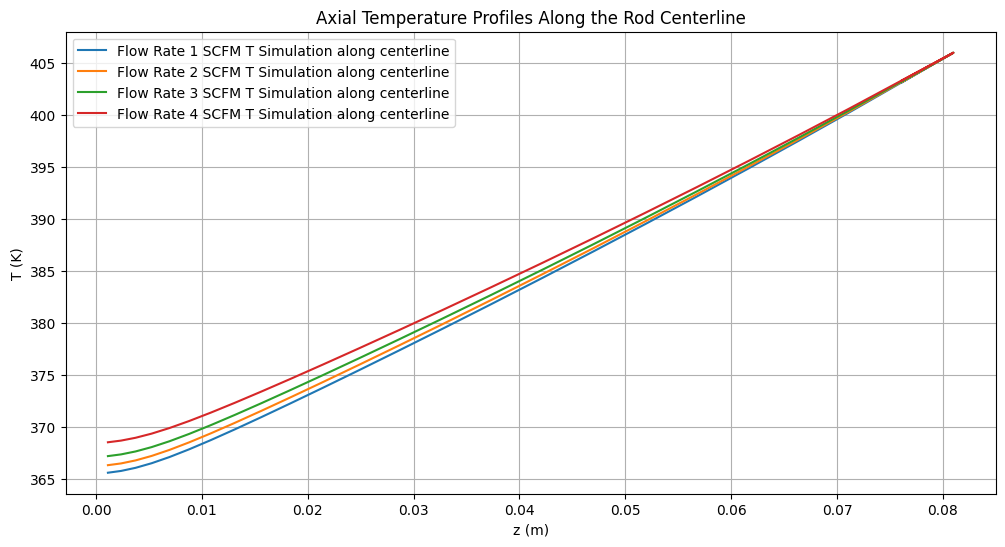

In [467]:
plt.figure(figsize=(12, 6))
plt.plot(df_sim_1.query("r == 0 and z > 0")['z'], df_sim_1.query("r == 0 and z > 0")['T (K)'], label = 'Flow Rate 1 SCFM T Simulation along centerline')
plt.plot(df_sim_2.query("r == 0 and z > 0")['z'], df_sim_2.query("r == 0 and z > 0")['T (K)'], label = 'Flow Rate 2 SCFM T Simulation along centerline')
plt.plot(df_sim_3.query("r == 0 and z > 0")['z'], df_sim_3.query("r == 0 and z > 0")['T (K)'], label = 'Flow Rate 3 SCFM T Simulation along centerline')
plt.plot(df_sim_4.query("r == 0 and z > 0")['z'], df_sim_4.query("r == 0 and z > 0")['T (K)'], label = 'Flow Rate 4 SCFM T Simulation along centerline')
plt.xlabel('z (m)')
plt.ylabel('T (K)')
plt.title('Axial Temperature Profiles Along the Rod Centerline')
plt.grid()
plt.legend()
plt.show()

$$ \textbf{Comment on any differences. Can you explain the differences? Discuss the shape} $$

Do in report

### Question 4
$$ \textbf{Plot the centerline temperature profile in the air as a function of distance from the brass-rod face (i.e., T(0, z<0)) at varying Vin.}$$

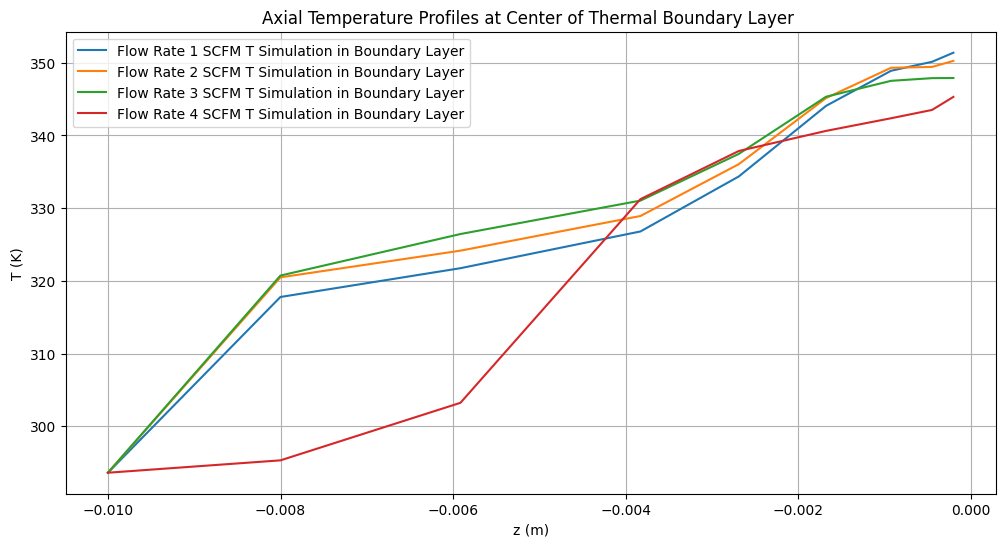

In [468]:
plt.figure(figsize=(12, 6))
plt.plot(df_sim_1.query("r == 0 and z < 0")['z'], df_sim_1.query("r == 0 and z < 0")['T (K)'], label = 'Flow Rate 1 SCFM T Simulation in Boundary Layer')
plt.plot(df_sim_2.query("r == 0 and z < 0")['z'], df_sim_2.query("r == 0 and z < 0")['T (K)'], label = 'Flow Rate 2 SCFM T Simulation in Boundary Layer')
plt.plot(df_sim_3.query("r == 0 and z < 0")['z'], df_sim_3.query("r == 0 and z < 0")['T (K)'], label = 'Flow Rate 3 SCFM T Simulation in Boundary Layer')
plt.plot(df_sim_4.query("r == 0 and z < 0")['z'], df_sim_4.query("r == 0 and z < 0")['T (K)'], label = 'Flow Rate 4 SCFM T Simulation in Boundary Layer')
plt.xlabel('z (m)')
plt.ylabel('T (K)')
plt.title('Axial Temperature Profiles at Center of Thermal Boundary Layer ')
plt.grid()
plt.legend()
plt.show()